In [1]:
import pandas as pd
from glob import glob
import numpy as np

import sys
sys.path.append("../scripts/") # go to parent dir

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from read_data import fromcsv2df, distribution, filtering, distribution_weights
from metrics import significance, significance_with_weight, prediction, significance_true_values
from plots import plot_scores_v2, plot_scores
from classification import classification_RF_with_tunning


In [8]:
source_path = "../processed_data/"

def run(signal_file,signal, category="mumuOS"):
    new_l = []
    # read CSV file containing a particular signal plus all the background
    df0 = fromcsv2df(signal_file) 
    print("Original variables", df0.columns)
    print("Num. rows (events):", df0.shape[0])
    print("Num. variables:", df0.shape[1])
    
    # getting the event weights 
    weights0 = df0['weight_column']
    
    # selecting features (by expert decision) plus label
    df = df0[['bveto', 'mt2t','nfj_w','hthad_fj','mt', 'met', 'htlep','label']]
    #display(df0)
    
    # data and label matrices
    y = df["label"]
    X = df.drop(columns=["label"])
    print("-------------")
    X,y, weights = filtering(df0,X,y,weights0, category)
    print("::: Filtered data :::")
    print("Num rows:", X.shape[0])
    print("Num variables:", X.shape[1])
    #display(X.head())
    
    # only features
    cols = ['bveto', 'mt2t','nfj_w','hthad_fj','mt', 'met', 'htlep']
    
    # Normalization
    X= (X-X.min())/(X.max()-X.min())
    X_temp = X.join(weights)
    
    
    # training, validation, and testing data
    X_train, X_test, y_train, y_test   = train_test_split(X_temp, y, test_size=0.2,random_state=1)
    #print("X_train.head()")
    #display(X_train.head())
    #print("X_test.head()")
    #display(X_test.head())
    
    train_w = X_train["weight_column"]
    test_w = X_test["weight_column"]
    
    X_test =X_test[cols]
    X_train =X_train[cols]

    # show distributions per classes
    dict_labels = {"y_train":y_train,"y_test": y_test}
    dict_weights = {"y_train": train_w, "y_test": test_w}
    
    
    
    df_distro_weights = distribution_weights(dict_labels, dict_weights)
    display(df_distro_weights)
    
    new_dict={}
    new_dict["signal"] = signal
    b_ = df_distro_weights["#background"].sum()
    new_dict["#back"] = b_
    s_ = df_distro_weights["#signal"].sum()
    new_dict["#sig"] = s_
    new_dict["%b"] = 100* (b_/(s_+b_))
    new_dict["%s"] = 100* (s_/(s_+b_))
    new_dict["tot. events"] = s_+ b_
    
    w_s = df_distro_weights["w_s"].sum()
    w_b = df_distro_weights["w_b"].sum()
    new_dict["w_s"] = w_s
    new_dict["w_b"] = w_b
    new_dict["%w_s"] = 100*(w_s/(w_s+w_b))
    new_dict["%w_b"] = 100*(w_b/(w_s+w_b))
    
    new_l.append(new_dict)
    SIGNIF = significance_true_values(y.values,y.values,weights.values)
    new_dict["SIGNIF_TRUE"] = SIGNIF
    
    
    # classification model using RandomForest
    clf = classification_RF_with_tunning(X_train, y_train,train_w)
    
    print("\n::: TRAIN PREDICTION :::\n")
    y_pred_train = clf.predict(X_train)
    y_pred_score_train = clf.predict_proba(X_train)
    metrics_train = prediction(y_train,  y_pred_score_train[:,1], title= "train", weights= train_w)
    
    print("\n::: TEST PREDICTION :::\n")
    y_pred=clf.predict(X_test)
    y_pred_score = clf.predict_proba(X_test) #1 - clf.predict_proba(X_test)[:,1] #!!!!!!!
    metrics = prediction(y_test, y_pred_score[:,1],title="testing",weights=test_w)
    
    
    mask_sig, mask_back, mask_sig_train, mask_back_train = plot_scores(y_pred_score[:,1], y_test,y_pred_score_train[:,1], y_train)
    plot_scores_v2(y_pred_score[:,1], mask_sig,mask_back,y_pred_score_train[:,1], mask_sig_train, mask_back_train, metrics, metrics_train, category,signal)

    
    print("classification_report TEST ::::")
    cr_test_w = classification_report(y_test, y_pred, sample_weight=test_w)
    cr_test = classification_report(y_test, y_pred)
    print(cr_test_w)
    print(cr_test)
    

    print("classification_report TRAIN ::::")
    cr_train_w =classification_report(y_train, y_pred_train, sample_weight=train_w)
    cr_train =classification_report(y_train, y_pred_train)
    print(cr_train_w)
    print(cr_train)
    

    
    return metrics, mask_sig, mask_back, y_pred, y_test, y_pred_score, y_pred_train, y_pred_score_train,mask_sig_train, mask_back_train, new_l
    

************************************************************
************************************************************
************************************************************
File: all_signal_m800_np_bg.csv
m800_np
Original variables Index(['mumuSS', 'mumuOS', 'emu', 'ee', 'mll', 'drll', 'drjl1', 'drjl2',
       'drlmet', 'dphi_ll', 'dphi_llmet', 'dphi_fj12', 'dphi_fj13',
       'dphi_fj23', 'met', 'mt', 'mt2t', 'bveto', 'hthad_rj', 'hthad_fj',
       'htlep', 'fj1mass', 'fj2mass', 'fj1pt', 'fj2pt', 'nel', 'nmu', 'nj',
       'nfj', 'nfj_w', 'label', 'weight_column', 'sample'],
      dtype='object')
Num. rows (events): 308113
Num. variables: 33
-------------
Category: mumuSS
::: Filtered data :::
Num rows: 4094
Num variables: 7
::::::::::s 11.996400000000001
::::::::::b 1283.917915620434
::::::::::s 3.2292000000000005
::::::::::b 295.81345898313424


,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF,SIGNIF_TRUE
0,train,1737,1538,53.038168,46.961832,3275,11.9964,1283.917916,0.925709,99.074291,1295.914316,0.334278,32.828911,0.334278
1,test,405,414,49.450549,50.549451,819,3.2292,295.813459,1.079846,98.920154,299.042659,0.187413,18.040918,0.187413


::::::::::s 15.2256
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


clf.classes_ [0 1]
1.9910080432891846

::: TRAIN PREDICTION :::

::::::::::s 11.9808
::::::::::b 1283.2798027632912
Significance ::::: 0.3339269448368946
yes 0.3339269448368946
::::::::::s 11.957400000000002
::::::::::b 1283.8133099061483
Significance ::::: 0.33320670811546155
::::::::::s 11.895000000000001
::::::::::b 1283.917915620434
Significance ::::: 0.33145706708302464
::::::::::s 11.7702
::::::::::b 1283.917915620434
Significance ::::: 0.3279847657690965
::::::::::s 11.528400000000001
::::::::::b 1283.917915620434
Significance ::::: 0.32125686446545554
::::::::::s 11.2632
::::::::::b 1283.917915620434
Significance ::::: 0.3138773942423061
::::::::::s 10.8108
::::::::::b 1283.917915620434
Significance ::::: 0.30128772280639554
::::::::::s 9.945
::::::::::b 1283.917915620434
Significance ::::: 0.27718960433152445
::::::::::s 8.736
::::::::::b 1283.917915620434
Significance ::::: 0.2435300772567569
::::::::::s 7.027800000000001
::::::::::b 1283.917915620434
Significance ::::: 0.195

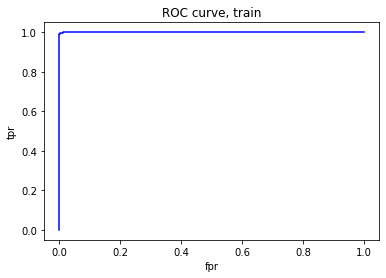

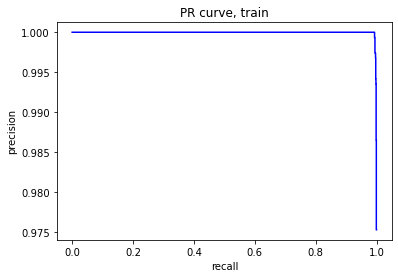

f1: 0.99 prec: 0.99 rec: 1.0 acc: 1.0 roc_auc 0.9999633165712523
[[1723   14]
 [   2 1536]]

::: TEST PREDICTION :::

::::::::::s 3.0888
::::::::::b 138.34322085055854
Significance ::::: 0.2616415128383385
yes 0.2616415128383385
::::::::::s 2.9094
::::::::::b 183.20478779426844
Significance ::::: 0.21438361280879079
::::::::::s 2.7768
::::::::::b 208.91994242414995
Significance ::::: 0.1916888426212873
::::::::::s 2.6442
::::::::::b 227.90512497428324
Significance ::::: 0.1748158027940194
::::::::::s 2.379
::::::::::b 239.38063492571072
Significance ::::: 0.15350868755245867
::::::::::s 2.184
::::::::::b 252.8326777439956
Significance ::::: 0.13715529419931338
::::::::::s 1.9422000000000001
::::::::::b 266.82201197142285
Significance ::::: 0.11875653671222759
::::::::::s 1.6614000000000002
::::::::::b 273.6785590851365
Significance ::::: 0.10032641615201268
::::::::::s 1.248
::::::::::b 279.52866619885015
Significance ::::: 0.07458967696885524
::::::::::s 0.7956000000000002
::::::::::b

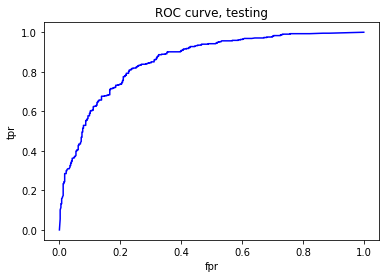

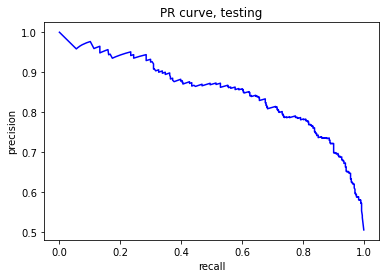

f1: 0.77 prec: 0.64 rec: 0.96 acc: 0.71 roc_auc 0.8586628496451364
[[183 222]
 [ 18 396]]
[189.  51.  33.  12.  24.  14.  12.  20.   9.   9.   3.  15.   7.   5.
   2.] 
 [18. 18. 11. 17. 12. 32. 10. 33. 14. 34. 27. 56. 30. 55. 47.]


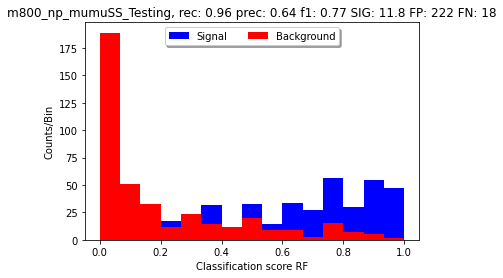

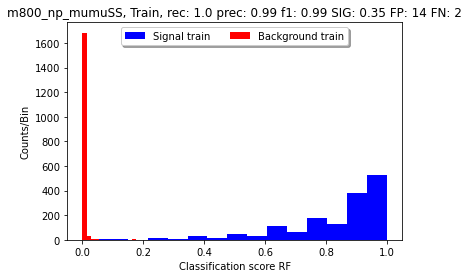

classification_report TEST ::::
              precision    recall  f1-score   support

           0       1.00      0.85      0.92 295.8134589831353
           1       0.05      0.68      0.09 3.2292000000000094

    accuracy                           0.85 299.0426589831353
   macro avg       0.52      0.77      0.51 299.0426589831353
weighted avg       0.99      0.85      0.91 299.0426589831353

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       405
           1       0.82      0.68      0.74       414

    accuracy                           0.76       819
   macro avg       0.77      0.76      0.76       819
weighted avg       0.77      0.76      0.76       819

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1283.9179156204448
           1       1.00      0.94      0.97 11.996399999999587

    accuracy                           1.00 1295.914315620

In [9]:
data_files = glob(f"{source_path}/all_signal*.csv")
l=[]

for i in data_files[0:1]:
    print("*"*60)
    print("*"*60)
    print("*"*60)
    print("File: "+ i.split("/")[-1])
    signal = i.split("/")[-1].split("_")[-3] + "_" + i.split("/")[-1].split("_")[-2] 
    print(signal)
    metrics, mask_sig, mask_back, y_pred, y_test, y_pred_score, y_pred_train, y_pred_score_train,mask_sig_train, mask_back_train, new_l = run(i,signal, category="mumuSS")
    metrics["signal"] = signal
    l.append(metrics)
    print("*"*20)
    
df_metrics = pd.DataFrame(l)
df_new = pd.DataFrame(new_l)

In [10]:
df_metrics

,f1,prec,rec,acc,cm,roc_auc,sig,threshold,signal
0,0.77,0.64,0.96,0.71,"[[183, 222], [18, 396]]",0.858663,11.8029,0.05,m800_np


In [5]:
df_new

,signal,#back,#sig,%b,%s,tot. events,w_s,w_b,%w_s,%w_b,SIGNIF_TRUE
0,m800_np,2142,1952,52.320469,47.679531,4094,15.2256,1579.731375,0.954609,99.045391,0.382461
